# Домашнее задание №1. Новопольский Артём

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chisquare

## Описание задания

1. Cгенерируйте 1000 значений в диапазоне от 5 до 105 методом `random()` и сохраните их в структуру `pandas.Series()`. Какой вид имеет распределение и почему именно такой? Что нужно сделать, чтобы распределение изменило форму?

2. Постройте гистограмму при помощи `matplotlib`. Рассчитайте основные статистические метрики для выборки вручную и в `python`.

3. Проведите аналогичные расчёты при помощи встроенных методов класса `pandas.Series()`.

## 1. Генерация данных

При помощи метода `np.random.random()` сгенерировано 1000 значений в диапазоне от 5 до 105. Значения сохранены в структуре данных `pd.Series()`.

In [2]:
distr = np.random.random(size=1000) * 100 + 5
distr_ser = pd.Series(distr)

## 2. Построение гистограммы выборки и определение вида распределения

При помощи библиотеки `matplotlib` построена гистограмма. 

Для расчёта количества интервалов (параметр `bins`) использовалось правило Стёрджеса, по которому:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
$bins=1+[log_{2}(N)]$, где $N$ - число наблюдений в выборке.


На гистограмме видно, что распределение сгененерированных данных является **равномерным**. Это объясняется тем, что метод `np.random.random()` генерирует данные именно из данного вида распределения. 

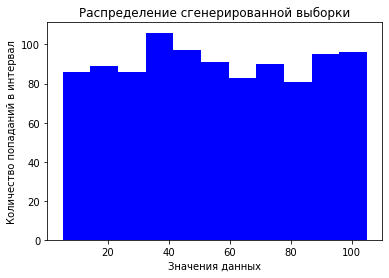

In [3]:
plt.title('Распределение сгенерированной выборки')
plt.xlabel('Значения данных')
plt.ylabel('Количество попаданий в интервал')
plt.hist(distr_ser, bins='sturges', color='blue')
plt.show()

*Чтобы распределение изменило форму*, можно добавить к нашим данным выбросы c обеих сторон:


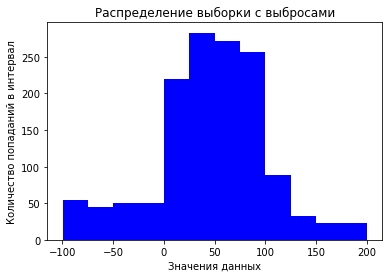

In [4]:
left_outliers = np.random.random(200) * (-100)
right_outliers = np.random.random(200) * 200
distr_with_outliers = np.concatenate((left_outliers, distr, right_outliers))

plt.title('Распределение выборки с выбросами')
plt.xlabel('Значения данных')
plt.ylabel('Количество попаданий в интервал')
plt.hist(distr_with_outliers, bins='sturges', color='blue')
plt.show()

С помощью **критерия Пирсона** проверим, соответствует ли исходная выборка и выборка с выбросами равномерному распределению. 
Нулевая гипотеза $H_{0}$ этого метода гласит, что распределение выборки соответсвует предполагаемому.

Для расчёта статистики и $p-value$ воспользуемся функцией `chisquare()` из библиотеки `scipy`. 

Также в расчетах нам пригодятся *самописные* функции для создания интервалов выборки `create_intervals()` и расчёта наблюдаемых и ожидаемых частот попадания значений выборки в эти интервалы `calc_uniform_freqs()`. Именно на основании значений наблюдаемых и ожидаемых частот и работает метод Пирсона.

Данные функции и расчёт представлены в ячейке ниже.

In [5]:
def create_intervals(sample):
    """ Создание интервалов для оценки частоты попадания значений выборки в них. """

    bins = 1 + int(np.log2(len(sample)))  # количество интервалов по правилу Стёрджеса
    borders = np.histogram_bin_edges(sample, bins)  # находим границы интервалов
    borders[0] -= 0.0001  # чтобы крайние значения из выборки попали в интервал
    borders[-1] += 0.0001 
    return [pd.Interval(borders[i], borders[i+1], closed="neither") for i in range(len(borders) - 1)]


def calc_uniform_freqs(sample, intervals):
    """ Расчёт наблюдаемых и ожидаемых частот попадания в интервал. """

    f_obs = [len([x for x in sample if x in interval]) for interval in intervals]
    f_exp = [len(sample) / len(f_obs)] * len(f_obs)
    return f_obs, f_exp


alpha = 0.05

# Применение критерия Пирсона к исходной выборке
intervals1 = create_intervals(distr_ser)
f_obs, f_exp = calc_uniform_freqs(distr_ser, intervals1)
chi2_stat, pvalue1 = chisquare(f_obs, f_exp, ddof=2)

# Применение критерия Пирсона к выборке с выбросами
intervals2 = create_intervals(distr_with_outliers)
f_obs, f_exp = calc_uniform_freqs(distr_with_outliers, intervals2)
chi2_stat, pvalue2 = chisquare(f_obs, f_exp, ddof=2)

# Сравнение результатов
print('Исходная выборка' + (' имеет равномерное распределение. H0 принимается, т.к ' if pvalue1 > alpha else ' имеет распределение, отличное от равномерного. H0 отвергается, т.к ') + ' p-value =', round(pvalue1, 2))
print('Выборка с выбросами' + (' имеет равномерное распределение. H0 принимается, т.к ' if pvalue2 > alpha else ' имеет распределение, отличное от равномерного. H0 отвергается, т.к ') + ' p-value =', round(pvalue2, 2))

Исходная выборка имеет равномерное распределение. H0 принимается, т.к  p-value = 0.33
Выборка с выбросами имеет распределение, отличное от равномерного. H0 отвергается, т.к  p-value = 0.0


На основе метода Пирсона было выявлено, что исходная выборка действительно имеет равномерное распределение. $p-value$ сильно превышает заданный уровень значимости 0.05, из-за чего мы не можем отклонить $H_{0}$.

Распределение же выборки, в которой присутствуют выбросы, действительно изменило свою форму, в чем мы также смогли убедиться при применении критерия Пирсона: $H_{0}$ пришлось отклонить, так как значение $p-value$ слишком мало при заданном уровне значимости 0.05.

## 3. Расчёт основных статистических метрик

Для полученной выборки рассчитаны основные статистические метрики 2-мя способами:
- "вручную"
- при помощи встроенных методов класса `pd.Series()`

### Расчет метрик "вручную"

Стоит отметить, что из-за **равномерного** характера сгенерированного распределения, его мода не может быть однозначно определена, так как каждое значение в выборке встречается с примерно одинаковой вероятностью.

Но в качестве упражнения были написаны расчёты всех мер центральной тенденции, мер изменчивости и квантилей.

In [6]:
# Меры центральной тенденции
def calc_mean(sample):
    """ Расчёт математического ожидания. """

    mean = 1 / len(sample) * sum(sample)
    return mean


def calc_median(sample):
    """ Расчёт медианы. """

    sample = sorted(sample)
    if len(sample) % 2 == 1:
        median = sample[len(sample) // 2]
    else:
        median = 0.5 * (sample[len(sample) // 2 - 1] + sample[len(sample) // 2])
    return median


def calc_mode(sample):
    """ Расчёт моды. """

    # Подсчёт количества вхождений каждого значения в выборку
    counts = {}
    for x in sample:
        if x not in counts:
            counts[x] = 1
        else:
            counts[x] += 1
  
  # Поиск значения с максимальным количеством вхождений
    max_count = 0
    mode = None
    for key, value in counts.items():
        if max_count < value:
            max_count = value
            mode = key

    return mode


# Меры изменчивости
def calc_biased_variability_measures(sample):
    """ Расчёт смещённых оценок дисперсии и среднеквадратического отклонения. """

    biased_variance = 1 / len(sample) * sum(((sample - calc_mean(sample)) ** 2))
    biased_std = biased_variance ** 0.5
    return biased_variance, biased_std


def calc_unbiased_variability_measures(sample):
    """ Расчёт несмещённых оценок дисперсии и среднеквадратического отклонения. """

    unbiased_variance = (1 / (len(sample) - 1)) * sum(((sample - calc_mean(sample)) ** 2))
    unbiased_std = unbiased_variance ** 0.5
    return unbiased_variance, unbiased_std


# Квантили
def calc_quantiles(sample, quantiles=[0.25, 0.5, 0.75]):
    """ Расчет значений квантилей выборки. """

    sample = sorted(sample)
    q_values = [sample[int(quantile * len(sample)) - 1] for quantile in quantiles]
    return dict(zip(quantiles, q_values))

Проверим результаты:

In [7]:
print(f'Медиана = {calc_median(distr_ser)}')
print(f'Мат. ожидание = {calc_mean(distr_ser)}')

biased_variance, biased_std = calc_biased_variability_measures(distr_ser)
print(f'Смещённая дисперсия = {biased_variance}')
print(f'Смещённое среднеквадратическое отклонение = {biased_std}')

unbiased_variance, unbiased_std = calc_unbiased_variability_measures(distr_ser)
print(f'Несмещённая дисперсии = {unbiased_variance}')
print(f'Несмещённое среднеквадратическое отклонение = {unbiased_std}')

quantiles = calc_quantiles(distr_ser, quantiles=[0.25, 0.5, 0.75])
for quantile, q_value in quantiles.items():
    print(f'{quantile}-квантиль = {q_value}')

Медиана = 55.005672852853344
Мат. ожидание = 55.189078484950976
Смещённая дисперсия = 833.5405621687643
Смещённое среднеквадратическое отклонение = 28.871102545084145
Несмещённая дисперсии = 834.3749371058701
Несмещённое среднеквадратическое отклонение = 28.885548932050263
0.25-квантиль = 31.420970461045822
0.5-квантиль = 54.9914838391291
0.75-квантиль = 80.6653869914512


### Расчёт метрик с помощью встроенных методов `pd.Series()`

In [8]:
print(f'Медиана = {distr_ser.median()}')
print(f'Мат. ожидание = {distr_ser.mean()}')

print(f'Смещённая дисперсия = {distr_ser.std(ddof=0) ** 2}')
print(f'Смещённое среднеквадратическое отклонение = {distr_ser.std(ddof=0)}')

print(f'Несмещённая дисперсии = {distr_ser.std(ddof=1) ** 2}')
print(f'Несмещённое среднеквадратическое отклонение = {distr_ser.std(ddof=1)}')

q_values = distr_ser.quantile(q=[0.25, 0.5, 0.75])
for quantile in q_values.index:
    print(f'{quantile}-квантиль = {q_values[quantile]}')

Медиана = 55.005672852853344
Мат. ожидание = 55.189078484950954
Смещённая дисперсия = 833.5405621687659
Смещённое среднеквадратическое отклонение = 28.871102545084174
Несмещённая дисперсии = 834.3749371058717
Несмещённое среднеквадратическое отклонение = 28.88554893205029
0.25-квантиль = 31.440289301796717
0.5-квантиль = 55.005672852853344
0.75-квантиль = 80.70021909448768


Заметим, что расчёт статистических метрик "вручную" и с помощью встроенных методов `pd.Series()` дал *одни и те же результаты*. Немного разнится лишь расчёт квантилей. Это связано с математическими особенностями их расчёта в методах `pd.Series()`, мы же брали определённый элемент из исходной отсортированной выборки.